In [1]:
# Use qt backend for matplotlab to use interactive mne plots
# %matplotlib qt

In [1]:
import mne 
import analysis.processing
mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

/Users/erangad/Documents/Research/oddball-task/ov_experiment/scenarios/data/P1/P1.gdf


/var/folders/x4/6xjb_tfs6vdg6llm0_l4vjz00000gn/T/ipykernel_21055/1878721723.py:19: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])


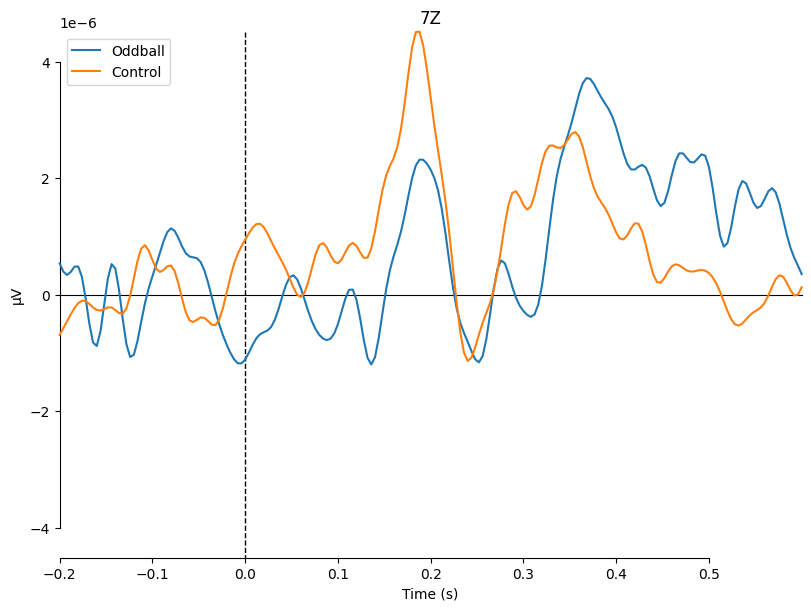

[<Figure size 800x600 with 1 Axes>]

In [3]:
participant_id = 1

# loading data
raw = analysis.processing.loadData(participant_id)

# preprocessig 
raw = analysis.processing.preprocessing(raw) 

#generate epochs
epochs_1, event_dict = analysis.processing.eventEpochdata(raw)


oddball = epochs_1["visual/image_display/onset/stimulus/non_freq"].average()
control = epochs_1["visual/image_display/onset/stimulus/freq"].average()

#PZ ~ 7Z

evokeds = dict(Oddball=oddball, Control=control)
mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])

/Users/erangad/Documents/Research/oddball-task/ov_experiment/scenarios/data/P2/P2.gdf


/var/folders/x4/6xjb_tfs6vdg6llm0_l4vjz00000gn/T/ipykernel_21055/630418971.py:19: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])


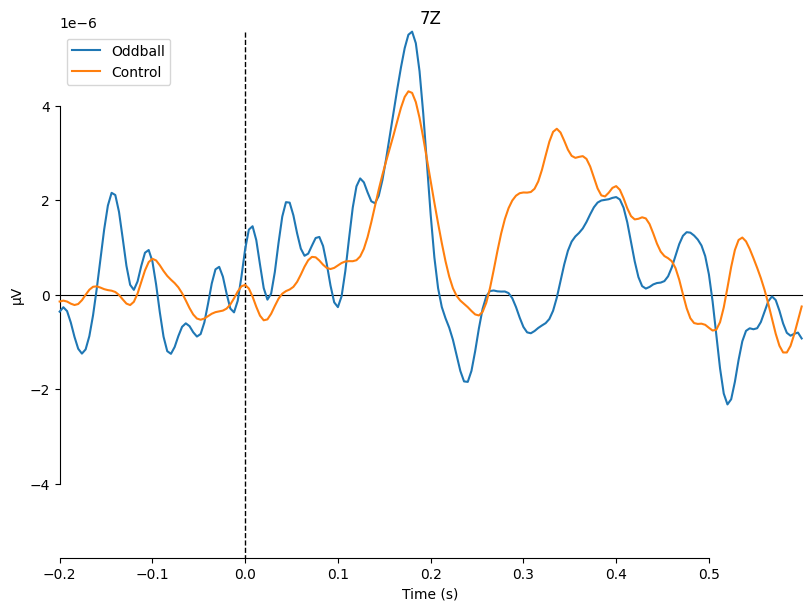

[<Figure size 800x600 with 1 Axes>]

In [4]:
participant_id = 2

# loading data
raw = analysis.processing.loadData(participant_id)

# preprocessig 
raw = analysis.processing.preprocessing(raw) 

#generate epochs
epochs_2, event_dict = analysis.processing.eventEpochdata(raw)


oddball = epochs_2["visual/image_display/onset/stimulus/non_freq"].average()
control = epochs_2["visual/image_display/onset/stimulus/freq"].average()

#PZ ~ 7Z

evokeds = dict(Oddball=oddball, Control=control)
mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])

Both sessions are from the same participant, here we are combining both of the sessions

/var/folders/x4/6xjb_tfs6vdg6llm0_l4vjz00000gn/T/ipykernel_21055/1928048206.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_combine  = mne.concatenate_epochs([epochs_1, epochs_2])
/var/folders/x4/6xjb_tfs6vdg6llm0_l4vjz00000gn/T/ipykernel_21055/1928048206.py:9: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])


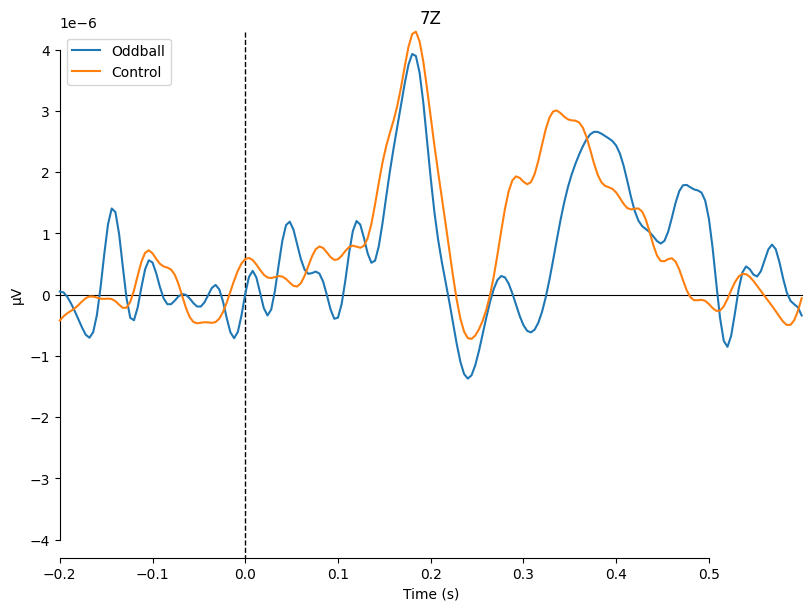

[<Figure size 800x600 with 1 Axes>]

In [5]:
epochs_combine  = mne.concatenate_epochs([epochs_1, epochs_2])

oddball = epochs_combine["visual/image_display/onset/stimulus/non_freq"].average()
control = epochs_combine["visual/image_display/onset/stimulus/freq"].average()

#PZ ~ 7Z

evokeds = dict(Oddball=oddball, Control=control)
mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])

/Users/erangad/Documents/Research/oddball-task/ov_experiment/scenarios/data/P3/P3.gdf


/var/folders/x4/6xjb_tfs6vdg6llm0_l4vjz00000gn/T/ipykernel_21055/2314236228.py:19: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])


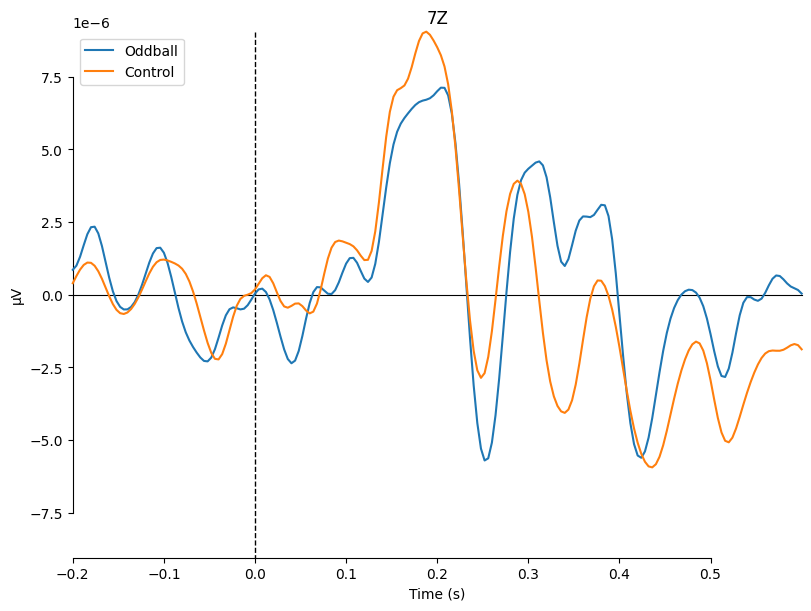

[<Figure size 800x600 with 1 Axes>]

In [6]:
participant_id = 3

# loading data
raw = analysis.processing.loadData(participant_id)

# preprocessig 
raw = analysis.processing.preprocessing(raw) 

#generate epochs
epochs_3, event_dict = analysis.processing.eventEpochdata(raw)


oddball = epochs_3["visual/image_display/onset/stimulus/non_freq"].average()
control = epochs_3["visual/image_display/onset/stimulus/freq"].average()

#PZ ~ 7Z

evokeds = dict(Oddball=oddball, Control=control)
mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])

c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P11/P11.gdf


C:\Users\erang\AppData\Local\Temp\ipykernel_10600\3122749094.py:19: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])


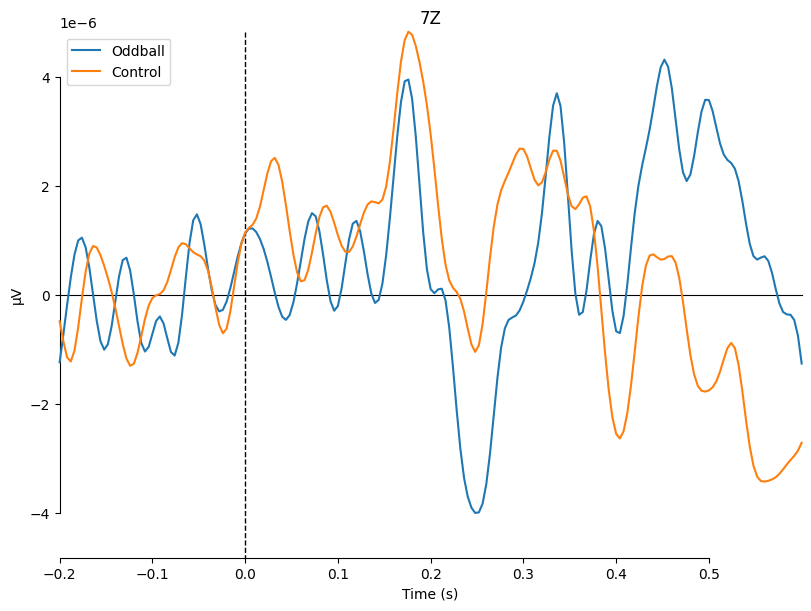

[<Figure size 800x600 with 1 Axes>]

In [2]:
participant_id = 11

# loading data
raw = analysis.processing.loadData(participant_id)

# preprocessig 
raw = analysis.processing.preprocessing(raw) 

#generate epochs
epochs_4, event_dict = analysis.processing.eventEpochdata(raw)


oddball = epochs_4["visual/image_display/onset/stimulus/non_freq"].average()
control = epochs_4["visual/image_display/onset/stimulus/freq"].average()

#PZ ~ 7Z

evokeds = dict(Oddball=oddball, Control=control)
mne.viz.plot_compare_evokeds(evokeds, picks=['7Z'])



c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P1/P1.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P3/P3.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P4/P4.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P5/P5.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P7/P7.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P8/P8.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P9/P9.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P10/P10.gdf
c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P11/P11.gdf


C:\Users\erang\AppData\Local\Temp\ipykernel_10600\1024370364.py:26: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, title = title, picks=roi, ci =0.9)


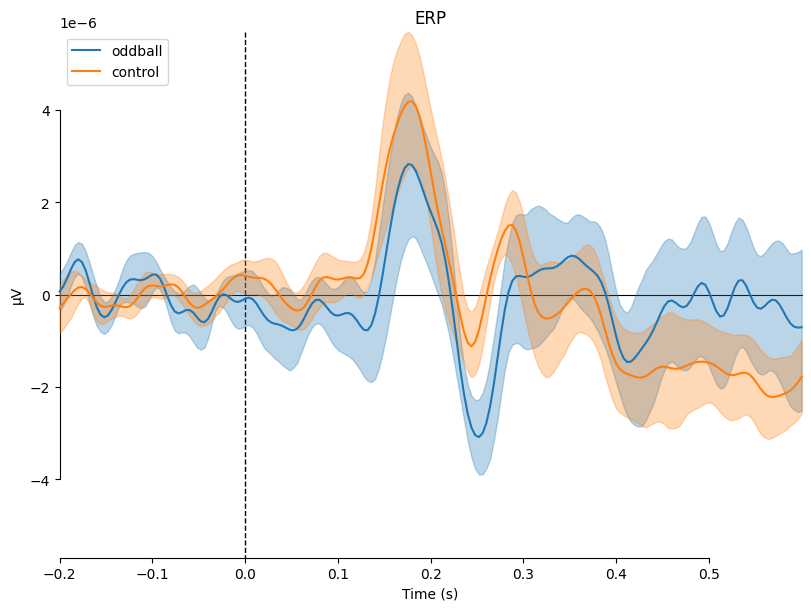

[<Figure size 800x600 with 1 Axes>]

In [3]:
oddball_list = []
control_list = []

for pnum in (1,3,4,5,7,8,9,10,11):
    raw = analysis.processing.loadData(pnum)

    # preprocessig 
    raw = analysis.processing.preprocessing(raw)
    epochs, event_dict = analysis.processing.eventEpochdata(raw)


    oddball = epochs["visual/image_display/onset/stimulus/non_freq"].average()
    control = epochs["visual/image_display/onset/stimulus/freq"].average()
    oddball_list.append(oddball)
    control_list.append(control)



title= "ERP"
roi =['7Z']

evokeds = dict(
    oddball=  oddball_list,
    control= control_list,
)
mne.viz.plot_compare_evokeds(evokeds, title = title, picks=roi, ci =0.9)


    

C:\Users\erang\AppData\Local\Temp\ipykernel_10600\2874193598.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, title = title, picks=roi, ci =0.8)


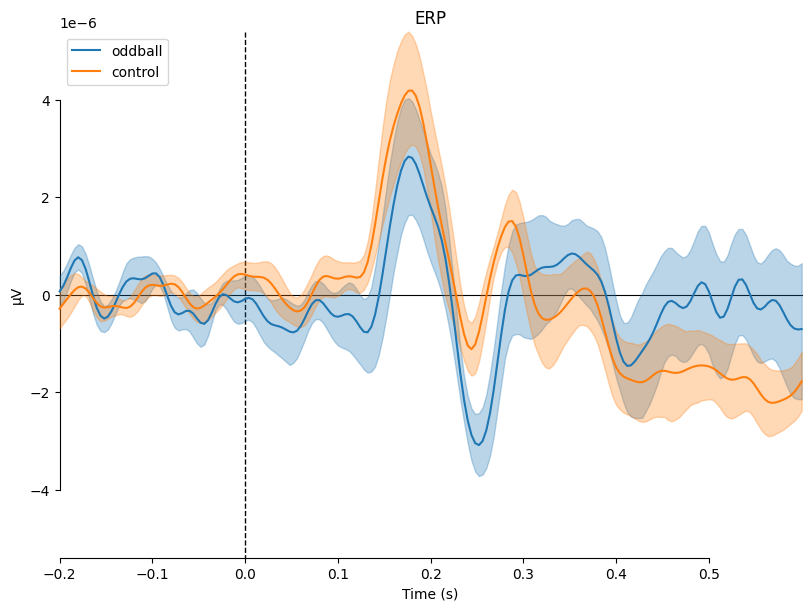

[<Figure size 800x600 with 1 Axes>]

In [4]:
mne.viz.plot_compare_evokeds(evokeds, title = title, picks=roi, ci =0.8)

In [6]:
diff_waves = []
for i in range(len(oddball_list)):
    diff_waves.append(mne.combine_evoked([oddball_list[i], control_list[i]], weights=[-1, 1]))

C:\Users\erang\AppData\Local\Temp\ipykernel_18972\1335212416.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds({contrast:diff_waves},


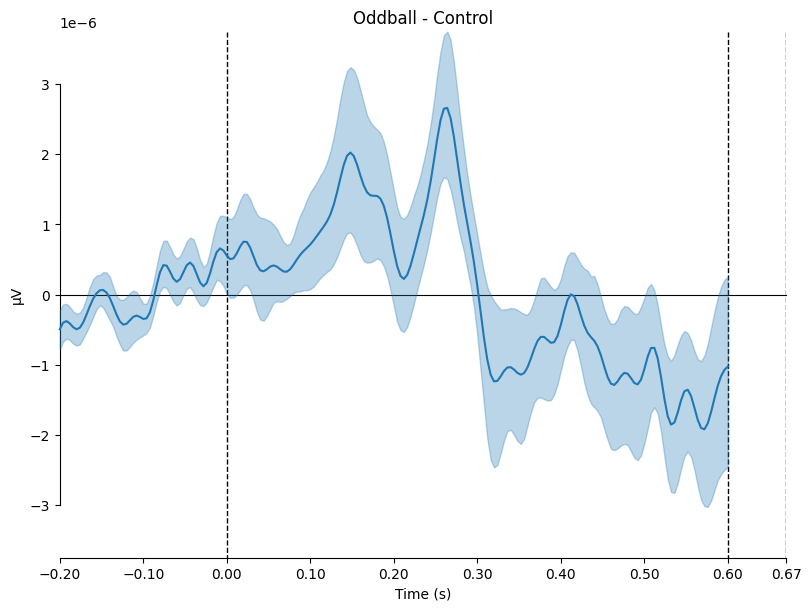

In [7]:
import matplotlib.pyplot as plt
contrast = 'Oddball - Control'
mne.viz.plot_compare_evokeds({contrast:diff_waves},
                            legend=None, title=contrast,
                             picks=roi, ci =0.8, vlines = [0.0, 0.6, 0.67]
                            )
plt.show()